In [ ]:
pip install jdatetime

  Created wheel for jdatetime: filename=jdatetime-3.6.2-cp37-none-any.whl size=11783 sha256=b7bc0c883303b987e8bddd0ee52755a5e730bef283803e64e6c0db12bdef1e10
  Stored in directory: /root/.cache/pip/wheels/ea/7d/d2/92961c39b79a0556bc4ce7c20185fdab84969ecb8fe2e5e8cc
Successfully built jdatetime


# Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import jdatetime

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# read csv file and convert to dataframe
data = pd.read_csv('/content/gdrive/My Drive/Datasets/train.csv')

In [ ]:
# get some information about dataframe like Dtype or number of non-null for each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    114 non-null    object 
 1   sale    114 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.9+ KB


In [ ]:
# extract new feature from data['date']
# new features like : year, month, day, weekday, week, weekend, yearday, season

def make_new_time_features(df):
  data = df.copy()
  year = []
  month = []
  day = []
  weekday = []
  week = []
  weekend = []
  yearday = []
  season = []

  for date in df['date']:

    splited_date = date.split('-')
    y = int(splited_date[0])  # split year from date and convert the type to 'int' : for example 1399 from 1399-05-30
    m = int(splited_date[1])  # split month from date and convert the type to 'int' : for example 5 from 1399-05-30
    d = int(splited_date[2])  # split day from date and convert the type to 'int' : for example 30 from 1399-05-30

    # extract season from month --> [1-3] : spring(1), [4-6] : summer(2), [7-9] : fall(3), [10-12] : winter(4)
    if 1 <= m <= 3 :
      s = 1
    elif 4 <= m <= 6 :
      s = 2
    elif 7 <= m <= 9 :
      s = 3
    elif 10 <= m <= 12 :
      s = 4
    # add day, month, year, season to arrays
    year.append(y)
    month.append(m)
    day.append(d)
    season.append(s)

    # convert date to jdatetime(jalali date time) for extracting more information like weekday, weeknumber, weekday, yearday
    fa_date = jdatetime.datetime(y, m, d, local='fa_IR')

    wd = fa_date.isoweekday() # day of week : a number between 1 to 7

    we = 0  # is weekend or not
    if wd == 6 or wd == 7:
      we = 1
    
    w = fa_date.weeknumber()  # which week of year : a number between 1 to 52
    yd = fa_date.yday()   # which day of year : a number between 1 to 366

    # add week, weekday, weekend, yearday to arrays
    week.append(w)
    weekday.append(wd)
    weekend.append(we)
    yearday.append(yd)
    
  # add new features extracted above to dataframe
  data['year'] = np.array(year)
  data['month'] = np.array(month)
  data['day'] = np.array(day)
  data['season'] = np.array(season)
  data['week'] = np.array(week)
  data['weekday'] = np.array(weekday)
  data['weekend'] = np.array(weekend)
  data['yearday'] = np.array(yearday)

  return data

new_data = make_new_time_features(data)

In [ ]:
new_data

,date,sale,year,month,day,season,week,weekday,weekend,yearday
0,1399-05-30,384.0,1399,5,30,2,23,6,1,154
1,1399-05-31,393.0,1399,5,31,2,23,7,1,155
2,1399-06-01,414.0,1399,6,1,2,24,1,0,156
3,1399-06-02,410.0,1399,6,2,2,24,2,0,157
4,1399-06-03,398.0,1399,6,3,2,24,3,0,158
...,...,...,...,...,...,...,...,...,...,...
109,1399-09-17,262.0,1399,9,17,3,39,3,0,263
110,1399-09-18,306.0,1399,9,18,3,39,4,0,264
111,1399-09-19,292.0,1399,9,19,3,39,5,0,265
112,1399-09-20,307.0,1399,9,20,3,39,6,1,266


In [ ]:
new_data['year'].value_counts()

1399    114
Name: year, dtype: int64

In [ ]:
# all years are 1399, so there is nothing special for the model to learn from

In [ ]:
droped_data = new_data.drop(['date', 'year'], axis=1)
droped_data = droped_data.sample(frac=1)

In [ ]:
# define X and y
X = droped_data.drop(['sale'], axis=1)
y = droped_data['sale']

In [ ]:
# Normalizing
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X)
Normalized_X = pd.DataFrame(normalizer.transform(X), columns=X.columns)

In [ ]:
# calculate mutual_info score
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)   # convert mi_scores to Pandas Series
    mi_scores = mi_scores.sort_values(ascending=False)  # sort mi_scores from large to small
    return mi_scores

# calculate mutual_info score for every type of rescaled_data in 'normal_data' dictionary
mi_score = make_mi_scores(Normalized_X, y)
print(mi_score)

season     0.577497
month      0.297702
yearday    0.263293
day        0.208554
weekend    0.139002
weekday    0.000000
week       0.000000
Name: MI Scores, dtype: float64


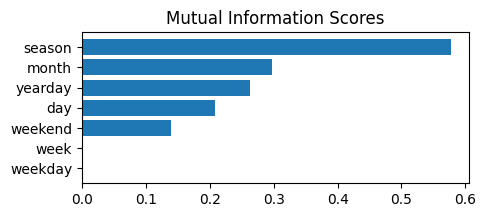

In [ ]:
# plot mi_scores
import matplotlib.pyplot as plt 

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

# plot mi_scores for 3 types of rescaled_data
plt.figure(dpi=100, figsize=(5, 2))
plt.show(plot_mi_scores(mi_score))

In [ ]:
# drop all features with zero MI-score : 'weekday', 'week'

X = Normalized_X.drop(['weekday', 'week'], axis=1)

In [ ]:
X

,month,day,season,weekend,yearday
0,0.035273,0.035273,0.013227,0.004409,0.987647
1,0.037982,0.006330,0.012661,0.000000,0.987540
2,0.033446,0.117059,0.011149,0.005574,0.981069
3,0.034315,0.060052,0.012868,0.000000,0.986570
4,0.034446,0.045928,0.011482,0.000000,0.987448
...,...,...,...,...,...
109,0.033086,0.090988,0.012407,0.004136,0.984320
110,0.032493,0.105602,0.012185,0.000000,0.982912
111,0.033843,0.071917,0.012691,0.000000,0.985688
112,0.033237,0.087248,0.012464,0.000000,0.984658


# Model Selection

In [ ]:
# define function for calculate 'Symmetric mean absolute percentage error'

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
# define func for calculate score-function

def smape_score(y_true, y_pred, **kwargs):
  smape_value = smape(y_true, y_pred)
  if smape_value > 17:
    return 0
  else:
    return (((17 - smape_value) / 17) ** 0.35) * 200

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer

# define smape_score function as a scorer for passing to cross_validate
smape_scorer = make_scorer(smape_score, greater_is_better=True)   
models_score = dict()   # dictionary for save all models' score

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# function for tuning models' hyperparameters
def find_best_params(model, x, y, params):
  searchCV = RandomizedSearchCV(model, param_distributions=params)
  searchCV.fit(x, y)
  return searchCV.best_params_

In [ ]:
# run cross_validate and return train_score, test_score, best parameters
def return_scores(model, X, y):
  cross_val = cross_validate(model, X, y, cv=5, scoring=smape_scorer, return_train_score=True)
  return {'train_score' : cross_val['train_score'], 
                       'test_score' : cross_val['test_score'],
                       'params' : best_params}

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

#Hyper Parameters Set
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10],
          'leaf_size':[1,2,3,5,6,7],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute']}

#Making models with hyper parameters sets
best_params = find_best_params(KNeighborsRegressor(), X, y, params)
model = KNeighborsRegressor(**best_params)
models_score['KNN'] = return_scores(model, X, y)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#hyper parameters set
params = {'n_estimators' : [100, 500, 900, 1100, 1500],
          'max_features' : ['auto', 'sqrt', 'log2', None],
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'min_samples_split':[2,3,4,5,6,7,8,9,10,11,12], 
          'random_state':[42]}

# fit model and save scores
best_params = find_best_params(RandomForestRegressor(), X, y, params)
model = RandomForestRegressor(**best_params)
models_score['RForest'] = return_scores(model, X, y)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

#Hyper Parameters Set
params = {'max_features': ['auto', 'sqrt', 'log2', None],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'random_state':[42]}

# fit model and save scores
best_params = find_best_params(DecisionTreeRegressor(), X, y, params)
model = DecisionTreeRegressor(**best_params)
models_score['DTree'] = return_scores(model, X, y)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

params = {'n_estimators' : [100, 500, 900, 1100, 1500],
          'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10,11] ,
          'min_samples_split' : [2,3,4,5,6,7,8,9,10,11,12],
          'max_features' : ['auto', 'sqrt', 'log2', None],
          'random_state':[42]}

# fit model and save scores
best_params = find_best_params(GradientBoostingRegressor(), X, y, params)
model = GradientBoostingRegressor(**best_params)
models_score['XGB'] = return_scores(model, X, y)

In [ ]:
from sklearn.linear_model import LinearRegression

# fit model and save scores
model = LinearRegression()
models_score['Linear'] = return_scores(model, X, y)

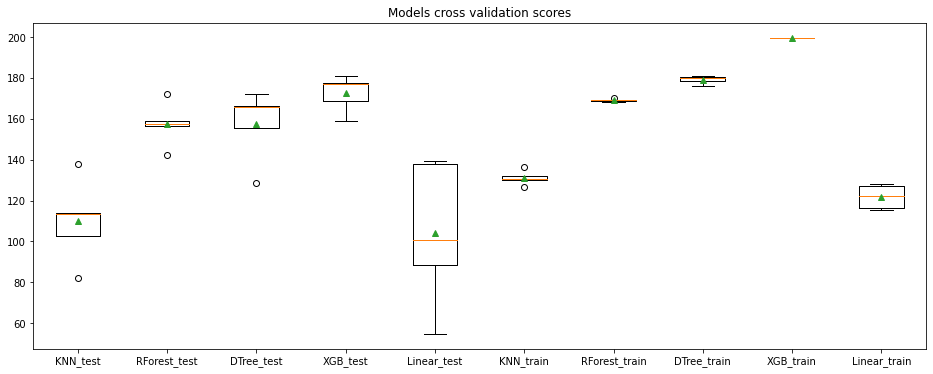

In [ ]:
# compare all models' score with boxplot

fig, ax = plt.subplots(figsize=(16,6))
ax.set_title('Models cross validation scores')

values = [x['test_score'] for x in models_score.values()] + [x['train_score'] for x in models_score.values()]
ax.boxplot(values, showmeans=True)
keys = [x+'_test' for x in models_score.keys()] + [x+'_train' for x in models_score.keys()]
ax.set_xticklabels(keys);

# Fine-tune and Fit Model

3


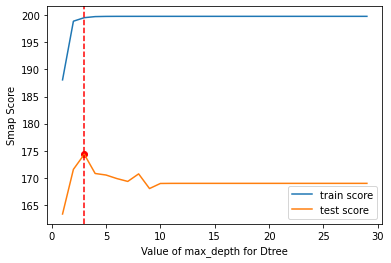

In [ ]:
# fine-tune GradientBoostingRegressor

from sklearn.model_selection import train_test_split

params = models_score['XGB']['params'].copy()
max_depths = range(1, 30)

xgb_test_scores = []
xgb_train_scores = []

# We use a loop through the range 1 to 30
# We append the scores in the list
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

for d in max_depths:
    xgb = GradientBoostingRegressor(**params, max_depth=d)
    xgb.fit(xtrain, ytrain)

    y_pred = dtree.predict(xtrain)
    dtree_train_scores.append(smape_score(ytrain, y_pred))

    y_pred = dtree.predict(xtest)
    dtree_test_scores.append(smape_score(ytest, y_pred))



# plot the relationship between K and testing smape-score
plt.plot(max_depths, dtree_train_scores, label='train score')
plt.plot(max_depths, dtree_test_scores, label='test score')

mx = dtree_test_scores.index(max(dtree_test_scores))+1
plt.axvline(x=mx, color='red', linestyle='--')
plt.scatter(mx, max(dtree_test_scores), color='red')

plt.legend()
plt.xlabel('Value of max_depth for Dtree')
plt.ylabel('Smap Score');
print(mx)

In [ ]:
params['max_depth'] = mx  # mx is the best max_depth for GradientBoostingRegressor
model = GradientBoostingRegressor(**params)
model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# Prediction

In [ ]:
# read and preprocess test data
output = pd.read_csv('/content/gdrive/My Drive/Datasets/output3.csv')
test_data = make_new_time_features(output)
test_data.drop(['sale', 'year', 'date']+['weekday', 'week'], axis=1, inplace=True)
test_data=pd.DataFrame(normalizer.transform(test_data))

In [ ]:
test_data

,0,1,2,3,4
0,0.033449,0.081763,0.011150,0.000000,0.996028
1,0.033315,0.085138,0.011105,0.000000,0.995750
2,0.033182,0.088486,0.011061,0.000000,0.995463
3,0.033050,0.091805,0.011017,0.000000,0.995167
4,0.032918,0.095097,0.010973,0.000000,0.994863
5,0.032787,0.098361,0.010929,0.003643,0.994544
6,0.032657,0.101599,0.010886,0.003629,0.994223
7,0.032528,0.104811,0.010843,0.000000,0.993901
8,0.032399,0.107996,0.010800,0.000000,0.993565
9,0.036074,0.003607,0.014429,0.000000,0.999238


In [ ]:
# model predicted values for test data

np.round(model.predict(test_data))

array([311., 302., 320., 330., 337., 343., 366., 360., 362., 375., 389.,
       395., 408., 422., 419., 442., 441., 374., 384., 385., 393., 388.,
       380., 378., 378., 402., 402., 392., 406., 401.])

In [ ]:
# save predicted values in output
output['sale'] = np.round(model.predict(test_data))

In [ ]:
# save output as csv
output.to_csv('/content/gdrive/My Drive/Datasets/output.csv', index=False)